In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hparquet as hparque
import helpers.hprint as hprint

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-3c1c29f2-7e1c-4c75-a614-2359544e19bd.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.7.0' != container_version='1.6.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='master'
  hash='6f1ff6a26'
  # Last commits:
    * 6f1ff6a26 Daniil Tikhomirov CMTask5403: Add logging schema (#5516)                            (   3 hours ago) Wed Sep 27 10:47:03 2023  (HEAD -> master, origin/master, origin/HEAD, CmTask5559_make_passivity_factor_optional)
    * 8837f381c Sameep Pote CmTask5432_Comment_out_incremental_argument_2 (#5484)             (   6 hours ago) Wed Sep 27 07:44:58 2023           
    *

# Build the config

In [4]:
dir_name = "/app/build_Mock2_tile_config_list.mock2.bloomberg_v1-top1.5T.2023-08-01_2023-08-31.run1/tiled_results"
config = {
    "dir_name": dir_name,
    "start_date": datetime.date(2023, 8, 1),
    "end_date": datetime.date(2023, 8, 31),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "B",
    "annotate_forecasts_kwargs": {
        "style": "longitudinal",
        "quantization": 30,
        "liquidate_at_end_of_day": True,
        "initialize_beginning_of_day_trades_to_zero": True,
        "burn_in_bars": 3,
        "compute_extended_stats": True,
        "target_dollar_risk_per_name": 1e2,
        "modulate_using_prediction_magnitude": True,
    },
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "vwap.ret_0.vol",
        "prediction_col": "vwap.ret_0.vol_adj.c",
    },
    "bin_annotated_portfolio_df_kwargs": {
        "proportion_of_data_per_bin": 0.2,
        "normalize_prediction_col_values": False,
    },
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /app/amp/build_Mock2_tile_config_list.mock2.bloomberg_v1-top1.5T.2023-08-01_2023-08-31.run1/tiled_results
start_date: 2023-08-01
end_date: 2023-08-31
asset_id_col: asset_id
pnl_resampling_frequency: B
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: True
  initialize_beginning_of_day_trades_to_zero: True
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 100.0
  modulate_using_prediction_magnitude: True
column_names: 
  price_col: vwap
  volatility_col: vwap.ret_0.vol
  prediction_col: vwap.ret_0.vol_adj.c
bin_annotated_portfolio_df_kwargs: 
  proportion_of_data_per_bin: 0.2
  normalize_prediction_col_values: False


# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1343146433,1,1,1,253.8 KB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

,,n_asset_ids,size
year,month,,
2023,8,1,253.8 KB


In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1343146433]

## Load a single-asset tile

In [9]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [11]:
single_tile_df.columns.levels[0].to_list()

['close',
 'close.ret_0',
 'high',
 'low',
 'month',
 'open',
 'twap',
 'twap.ret_0',
 'volume',
 'vwap',
 'vwap.ret_0',
 'vwap.ret_0.vol',
 'vwap.ret_0.vol_adj',
 'vwap.ret_0.vol_adj.c',
 'year']

In [12]:
single_tile_df.head(3)

,close,close.ret_0,high,low,month,open,twap,twap.ret_0,volume,vwap,vwap.ret_0,vwap.ret_0.vol,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,year
asset_id,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433
end_ts,,,,,,,,,,,,,,,
2023-08-01 13:35:00+00:00,334.9015,NaN,335.6500,333.70,8,335.090,334.53146,NaN,1432621.0,334.486456,NaN,NaN,NaN,NaN,2023
2023-08-01 13:40:00+00:00,334.4840,-0.001247,335.5000,333.85,8,334.900,334.45056,-0.000242,352567.0,334.441440,-0.000135,0.000135,NaN,NaN,2023
2023-08-01 13:45:00+00:00,335.2300,0.002230,335.6599,334.43,8,334.885,335.37426,0.002762,328131.0,335.374821,0.002791,0.001991,NaN,NaN,2023


# Compute portfolio bar metrics

In [13]:
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    asset_ids=None,
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
    return_portfolio_df=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100


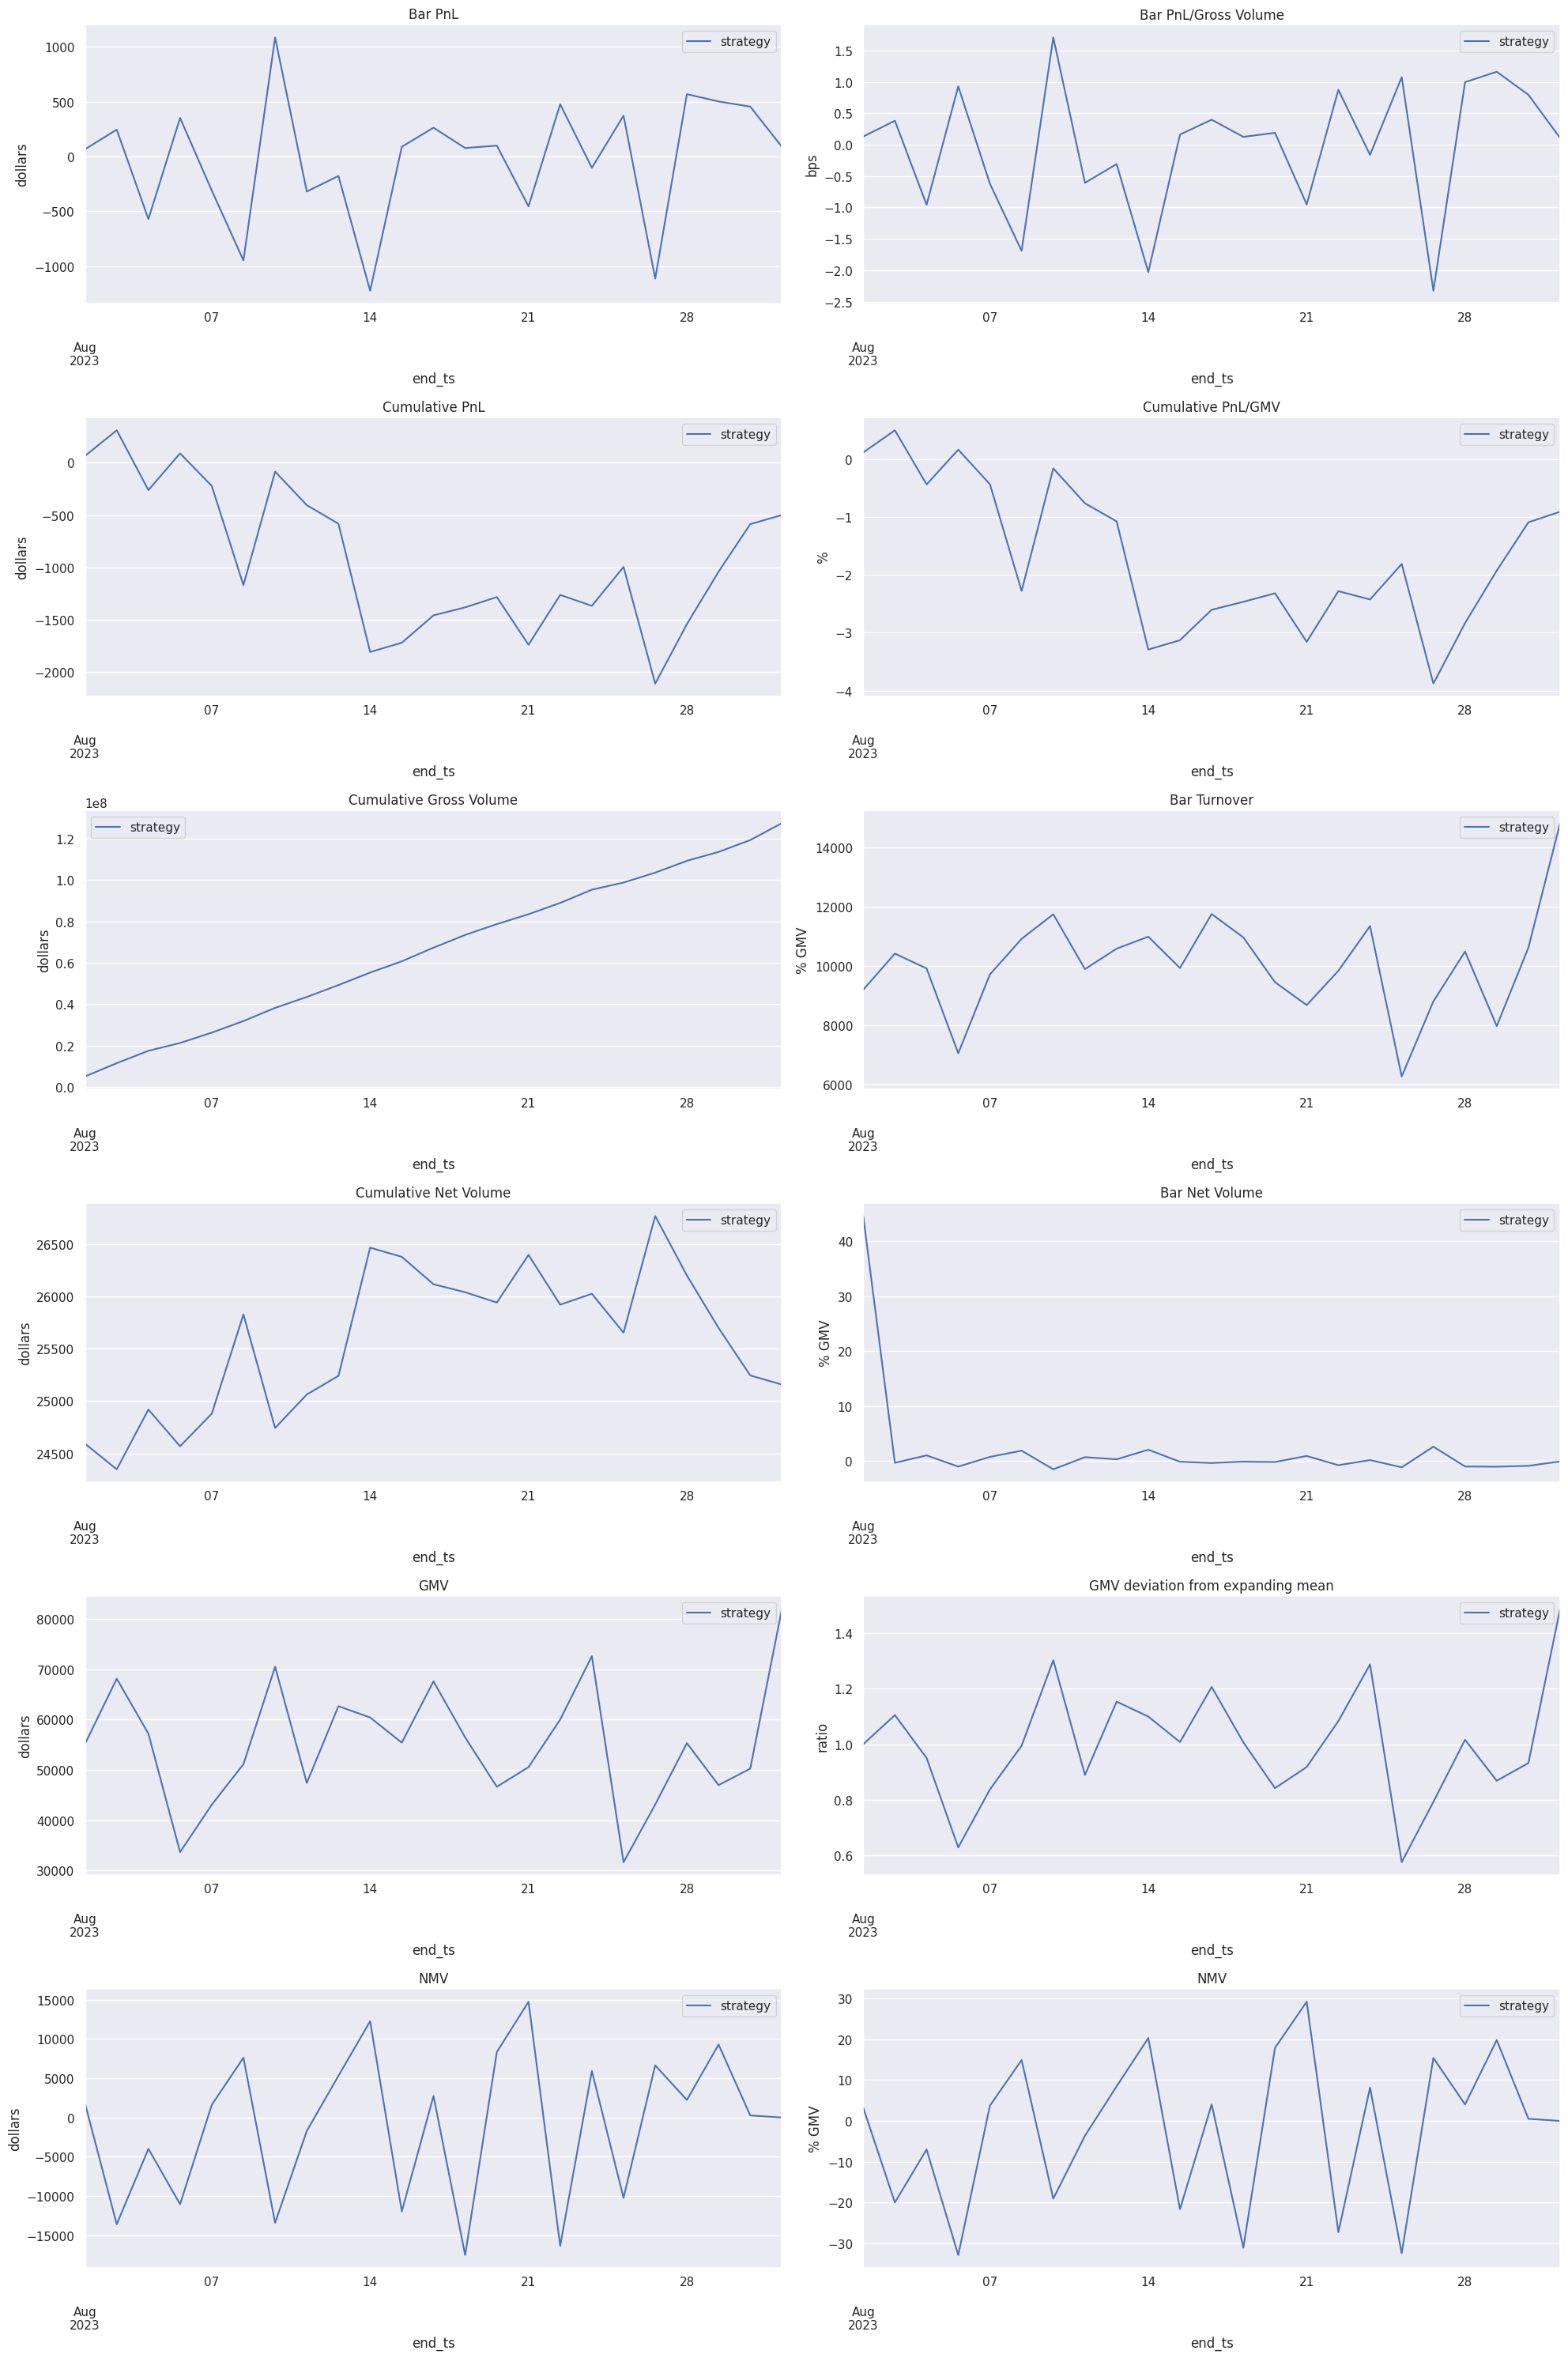

In [14]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

,pnl,pnl_in_bps,sgn_corr,hit_rate
prediction,,,,
"(-inf, -0.842]",5.846987,0.845376,0.045455,0.522727
"(-0.842, -0.253]",-0.315771,-0.363408,-0.041096,0.479452
"(-0.253, 0.253]",-0.908447,-0.464370,-0.027027,0.486486
"(0.253, 0.842]",0.450653,-0.133186,0.000000,0.500000
"(0.842, inf]",-6.912775,-1.689026,-0.116667,0.441667


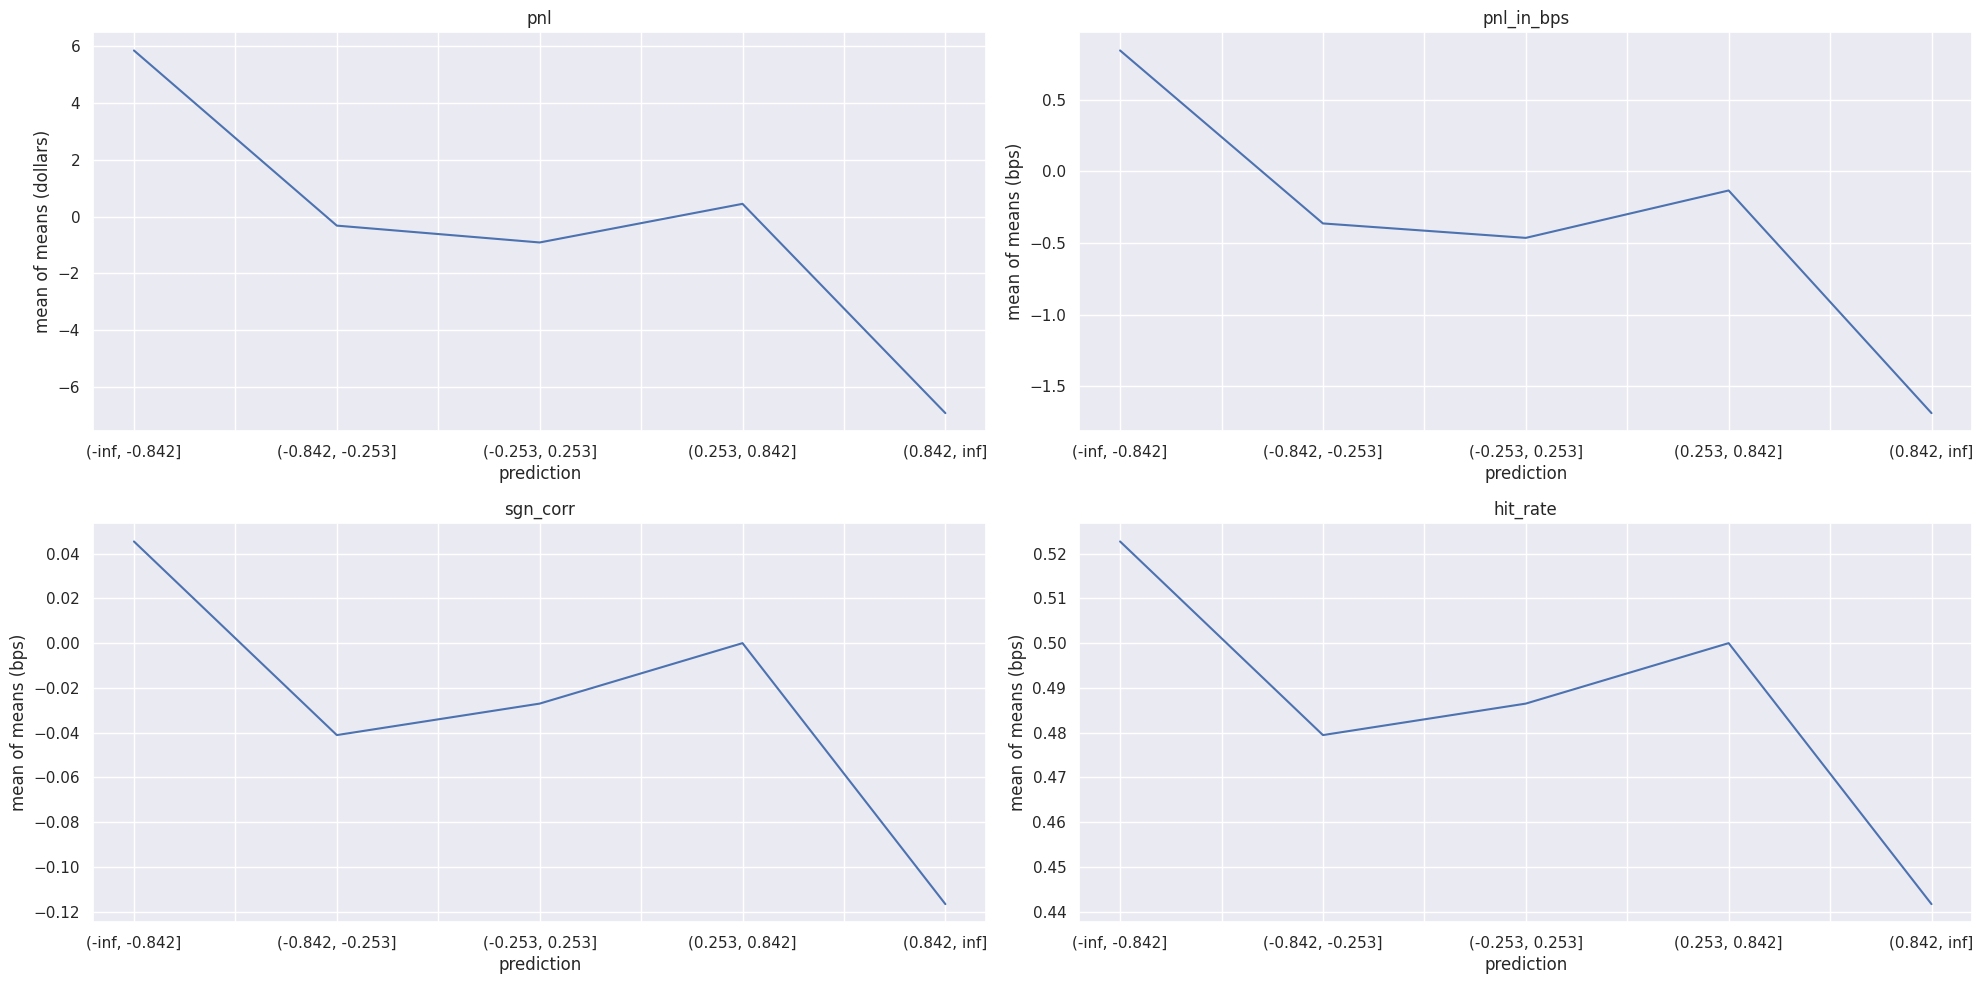

In [15]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [16]:
stats_computer = dtfmod.StatsComputer()

In [17]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["pnl_resampling_frequency"],
)
display(portfolio_stats)

ratios      sharpe_ratio                        -0.62
            sharpe_ratio_standard_error          3.44
            sr.tval                             -0.18
            sr.pval                              0.86
            kratio                              -2.23
dollar      gmv_mean                         55129.41
            gmv_stdev                        12189.30
            annualized_mean_return           -5671.63
            annualized_volatility             9120.73
            max_drawdown                      2420.28
            pnl_mean                           -21.74
            pnl_std                            564.69
            turnover_mean                  5541217.84
            turnover_stdev                  995583.46
            market_bias_mean                  -920.70
            market_bias_stdev                 9569.61
percentage  annualized_mean_return             -10.29
            annualized_volatility               16.54
            max_drawdown    